# Problem Division by Biomass Amount

# Optimization

## Set Variables

In [23]:
import pandas as pd
import logging
import os 
from itertools import product
from mip import Model, xsum, minimize, OptimizationStatus, BINARY
from datetime import datetime
import numpy as np
import sys
sys.path.append('../..')
from utils.config import LS_INDUSTRY_EXT
from utils.help import get_n_closer
from sklearn.cluster import AgglomerativeClustering

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

SYNTH_DATA_PATH = '../data'
OUT_SYNTH_DATA_PATH = '../output'
FORECAST_FILE = 'Biomass_History_Synthetic.csv' # Forecast File (Synthetic at the beginning) Path
DISTANCE_FILE = 'Distance_Matrix_Synthetic.csv' # Forecast File (Synthetic at the beginning) Path

TRANSPORT_FACTOR_A = .001

DEPOT_LOWER_THRESHOLD = 5000
DEPOT_UPPER_THRESHOLD = 17000
REF_LOWER_THRESHOLD = 20000
REF_UPPER_THRESHOLD = 85000
CLUSTER = 1 # Cluster to be optimized

cap_b_j = 20000 # Maximum depot capacity
cap_p_k = 100000 # Maximum production capacity
n_refineries = 5 # Number of refineries
n_depots = 25 # Number of depots


np.random.seed(42)

## Load and Process Data

In [24]:
# df_diff = df_fc['2018'] - df_fc['2019']
# df_diff.abs().plot(figsize=(15,5))
# df_diff.plot(figsize=(15,5))

In [25]:
# df_diff[df_diff.abs() < 100].plot()

In [26]:
df_fc = pd.read_csv(os.path.join(SYNTH_DATA_PATH, FORECAST_FILE))
df_matrix_orig = pd.read_csv(os.path.join(SYNTH_DATA_PATH, DISTANCE_FILE), 
                            index_col=0)

d_matrix_orig = df_matrix_orig.values

logging.info(f"\nCLUSTERING WITH AGGLOMERATIVE AVERAGE METHOD\n")                  
agg_clus = AgglomerativeClustering(n_clusters=3, linkage='average', metric="precomputed").\
            fit(d_matrix_orig, df_fc[['Latitude', 'Longitude']])
            
df_clus = df_fc.copy()
df_clus['Cluster'] = agg_clus.labels_
df_clus['avg_fc'] = df_clus.loc[:, ['2018', '2019']].mean(axis=1)
total_avg = df_clus['avg_fc'].sum()
d_clus = df_clus.groupby('Cluster')['avg_fc'].sum().to_dict()

d_clus_18 = df_clus.groupby('Cluster')['2018'].sum().to_dict()
d_clus_19 = df_clus.groupby('Cluster')['2019'].sum().to_dict()

d_depots = {k: (v // DEPOT_UPPER_THRESHOLD + 1) if v > DEPOT_LOWER_THRESHOLD else 0 for k, v in d_clus.items()}
d_refs = {k: (v // REF_UPPER_THRESHOLD + 1) if v > REF_LOWER_THRESHOLD else 0 for k, v in d_clus.items()}
d_depots_18 = {k: int(v // DEPOT_UPPER_THRESHOLD + 1) if v > DEPOT_LOWER_THRESHOLD else 0 for k, v in d_clus_18.items()}
d_depots_19 = {k: int(v // DEPOT_UPPER_THRESHOLD + 1) if v > DEPOT_LOWER_THRESHOLD else 0 for k, v in d_clus_19.items()}

# d_depots = {k: for k, v in d_clus.items()}
d_depots_min = {k: np.ceil(np.max([d_clus_18[k], d_clus_19[k]]) * 0.8 / DEPOT_UPPER_THRESHOLD) for k, v in d_clus.items()}
d_depots_max = {k: np.floor(np.min([d_clus_18[k], d_clus_19[k]]) / DEPOT_UPPER_THRESHOLD) for k, v in d_clus.items()}

d_idxs_clus = {k: list(ls_idxs) for k, ls_idxs in df_clus.groupby('Cluster').groups.items()}
d_intradist = {k: d_matrix_orig[d_idxs_clus[k], :][:, d_idxs_clus[k]].max() for k in d_idxs_clus.keys()}

for k, v in d_idxs_clus.items():
    logging.info(f"GROUP: {k} - DEPOTS: {d_depots[k]} - REFINERIES: {d_refs[k]} - N POINTS: {len(v)}"+\
                    f" - BIOMASS 2018: {d_clus_18[k]:.2f} - BIOMASS 2019: {d_clus_19[k]:.2f} - MAX INTRADISTANCE: {d_intradist[k]:.2f}")
print()
logging.info(f"TOTAL DEPOTS: {sum(d_depots.values())}")
logging.info(f"TOTAL DEPOTS 18: {sum(d_depots_18.values())}")
logging.info(f"TOTAL DEPOTS 19: {sum(d_depots_19.values())}")
logging.info(f"PCT COVERED (CONSTRAINED): {sum([v for k, v in d_clus.items() if  (d_depots[k] != 0)&(d_depots_min[k]<=d_depots_max[k])]) / sum(d_clus.values()):.2%}")
logging.info(f"PCT COVERED (UNCONSTRAINED): {sum([v for k, v in d_clus.items() if  (d_depots[k] != 0)]) / sum(d_clus.values()):.2%}")

IDX_CLUS = d_idxs_clus[CLUSTER] # Indexes of the cluster
n_depots = d_depots[CLUSTER] # Number of depots

df_fc_clus = df_fc.loc[IDX_CLUS, :].copy()
total_fc_18 = df_fc_clus.loc[:, '2018'].sum()
total_fc_19 = df_fc_clus.loc[:, '2019'].sum()
# df_fc_prep = df_fc.copy()
# df_fc_prep['avg_fc'] = df_fc_prep.loc[:, ['2018', '2019']].mean(axis=1)

df_matrix = df_matrix_orig.iloc[IDX_CLUS, IDX_CLUS]

df_matrix_obj = TRANSPORT_FACTOR_A * df_matrix.copy()

print('Total forecast 2018: {:.2f}'.format(total_fc_18))
print('Total forecast 2019: {:.2f}'.format(total_fc_19))
print('Distance matrix shape: {}'.format(df_matrix.shape))

2023-08-19 12:57:34 - INFO - 
CLUSTERING WITH AGGLOMERATIVE AVERAGE METHOD

2023-08-19 12:57:34 - INFO - GROUP: 0 - DEPOTS: 11.0 - REFINERIES: 3.0 - N POINTS: 1175 - BIOMASS 2018: 112381.21 - BIOMASS 2019: 228508.87 - MAX INTRADISTANCE: 638.97
2023-08-19 12:57:34 - INFO - GROUP: 1 - DEPOTS: 8.0 - REFINERIES: 2.0 - N POINTS: 941 - BIOMASS 2018: 129818.52 - BIOMASS 2019: 130846.21 - MAX INTRADISTANCE: 546.40
2023-08-19 12:57:34 - INFO - GROUP: 2 - DEPOTS: 2.0 - REFINERIES: 1.0 - N POINTS: 302 - BIOMASS 2018: 31250.26 - BIOMASS 2019: 25501.94 - MAX INTRADISTANCE: 306.28
2023-08-19 12:57:34 - INFO - TOTAL DEPOTS: 21.0
2023-08-19 12:57:34 - INFO - TOTAL DEPOTS 18: 17
2023-08-19 12:57:34 - INFO - TOTAL DEPOTS 19: 24
2023-08-19 12:57:34 - INFO - PCT COVERED (CONSTRAINED): 39.60%
2023-08-19 12:57:34 - INFO - PCT COVERED (UNCONSTRAINED): 100.00%



Total forecast 2018: 129818.52
Total forecast 2019: 130846.21
Distance matrix shape: (941, 941)


## Dimensionality Reduction by Distance

In [27]:
## REDUCE CANDIDATES 3: DELETE ARCS LONGER THAN MAXIMUM DISTANCE
MAX_DISTANCE = 600.
# idxs = df_matrix.where(df_matrix <= MAX_DISTANCE)
st_df_matrix = df_matrix.stack().copy()
st_df_matrix = st_df_matrix[st_df_matrix <= MAX_DISTANCE]
df_arcs_ij = pd.DataFrame(st_df_matrix.index.get_level_values(1), 
                          index=st_df_matrix.index.get_level_values(0)).reset_index()
df_arcs_ij.columns = ['i', 'j']
df_arcs_ij['j'] = df_arcs_ij['j'].astype(int)
ls_arcs_ij = df_arcs_ij.values
d_arcs_ij = {}
d_arcs_ji = {}
for key, value in ls_arcs_ij:
    d_arcs_ij.setdefault(key, []).append(value)
    d_arcs_ji.setdefault(value, []).append(key)

ls_arcs_jk = ls_arcs_ij.copy()
d_arcs_jk = d_arcs_ij.copy()
d_arcs_kj = d_arcs_ji.copy()

del df_arcs_ij

ls_biosource = list(d_arcs_ij.keys()) # range(N) # ls_dep_red
ls_depots = list(d_arcs_ji.keys()) # range(N) # ls_dep_red
ls_refineries = list(d_arcs_jk.keys()) # range(N) # ls_dep_red
# Get the forecasted biomass for year 2018 of all the positions
d_bio_18 = df_fc_clus.loc[ls_biosource, '2018']
d_bio_18 = d_bio_18.to_dict()
logging.info(f"Forecasted biomass for year 2018: {total_fc_18}")


d_bio_19 = df_fc_clus.loc[ls_biosource, '2019']
d_bio_19 = d_bio_19.to_dict()
logging.info(f"Forecasted biomass for year 2019: {total_fc_19}")

2023-08-19 12:57:34 - INFO - Forecasted biomass for year 2018: 129818.515738875
2023-08-19 12:57:34 - INFO - Forecasted biomass for year 2019: 130846.21458352602


## Variables Definition

In [28]:
# Get the solution for the optimization problem
logging.info("\nDefine model\n")
m = Model(sense=minimize)
m.threads = -1

# Variables: biomass b_{i, 0}
# 1. All values (forecasted biomass, biomass demand-supply, pellet demand-supply) must be
# greater than or equal to zero.

logging.info("SET VARIABLES")
b_18 = [m.add_var(name=f'b_2018_{i}_{j}', lb=0) for i, j in ls_arcs_ij]
logging.info(f"Variables b_2018: {len(b_18)}")

b_19 = [m.add_var(name=f'b_2019_{i}_{j}', lb=0) for i, j in ls_arcs_ij]
logging.info(f"Variables b_2019: {len(b_19)}")

p_18 = [m.add_var(name=f'p_2018_{j}_{k}', lb=0) for j, k in ls_arcs_jk]
logging.info(f"Variables p_2018: {len(p_18)}")

p_19 = [m.add_var(name=f'p_2019_{j}_{k}', lb=0) for j, k in ls_arcs_jk]
logging.info(f"Variables p_2019: {len(p_19)}")

x = [m.add_var(name=f'x_{j}', var_type=BINARY) for j in ls_depots]
logging.info(f"Variables x: {len(x)}")

r = [m.add_var(name=f'r_{k}', var_type=BINARY) for k in ls_refineries]
logging.info(f"Variables r: {len(r)}")

2023-08-19 12:57:34 - INFO - 
Define model

2023-08-19 12:57:34 - INFO - SET VARIABLES
2023-08-19 12:57:36 - INFO - Variables b_2018: 885481
2023-08-19 12:57:38 - INFO - Variables b_2019: 885481
2023-08-19 12:57:40 - INFO - Variables p_2018: 885481
2023-08-19 12:57:42 - INFO - Variables p_2019: 885481
2023-08-19 12:57:42 - INFO - Variables x: 941
2023-08-19 12:57:42 - INFO - Variables r: 941


In [29]:
153 ** 2

23409

## Constraints

In [30]:

# Constraints:
# 2. The amount of biomass procured for processing from each harvesting site ′𝑖𝑖′ must be less than
# or equal to that site’s forecasted biomass.
logging.info("\nSET CONSTRAINTS")
logging.info("Constraint 2: The processed biomass from each HS <= FC Biomass")
for i in ls_biosource:
    m += xsum(m.var_by_name(f'b_2018_{i}_{j}') for j in d_arcs_ij[i]) <= d_bio_18[i]
    m += xsum(m.var_by_name(f'b_2019_{i}_{j}') for j in d_arcs_ij[i]) <= d_bio_19[i]

logging.info("Constraint 3-4: Can't transport more than storage limit")
for j in ls_depots:
    # 3-4. Can't transport more than storage limit
    m += xsum(m.var_by_name(f'b_2018_{i}_{j}') for i in d_arcs_ji[j]) <= cap_b_j * m.var_by_name(f'x_{j}')
    m += xsum(m.var_by_name(f'b_2019_{i}_{j}') for i in d_arcs_ji[j]) <= cap_b_j * m.var_by_name(f'x_{j}')

for k in ls_refineries:
    m += xsum(m.var_by_name(f'p_2018_{j}_{k}') for j in d_arcs_kj[k]) <= cap_p_k * m.var_by_name(f'r_{k}')
    m += xsum(m.var_by_name(f'p_2019_{j}_{k}') for j in d_arcs_kj[k]) <= cap_p_k * m.var_by_name(f'r_{k}')

logging.info("Constraint 8: Pellets in = Pellets out")
for j in ls_depots:
    # 8. Total amount of biomass entering each preprocessing depot is equal to the total amount of
    # pellets exiting that depot (within tolerance limit of 1e-03
    
    m += xsum(m.var_by_name(f'b_2018_{i}_{j}') for i in d_arcs_ji[j])\
          - xsum(m.var_by_name(f'p_2018_{j}_{k}') for k in d_arcs_jk[j])\
           <= .001 # * m.var_by_name(f'x_{j}')
    
    m += xsum(m.var_by_name(f'p_2018_{j}_{k}') for k in d_arcs_jk[j])\
        - xsum(m.var_by_name(f'b_2018_{i}_{j}') for i in d_arcs_ji[j])\
        <= .001 # * m.var_by_name(f'x_{j}')

    m += xsum(m.var_by_name(f'b_2019_{i}_{j}') for i in d_arcs_ji[j])\
          - xsum(m.var_by_name(f'p_2019_{j}_{k}') for k in d_arcs_jk[j])\
           <= .001 # * m.var_by_name(f'x_{j}')
    
    m += xsum(m.var_by_name(f'p_2019_{j}_{k}') for k in d_arcs_jk[j])\
        - xsum(m.var_by_name(f'b_2019_{i}_{j}') for i in d_arcs_ji[j])\
        <= .001 #* m.var_by_name(f'x_{j}')

logging.info(f"Constraint 5: Number of depots should be less than or equal to {n_depots}")
# 5. Number of depots should be less than or equal to 25.
m += xsum(m.var_by_name(f'x_{j}') for j in ls_depots) <= n_depots

logging.info("Constraint 6: Number of refineries should be less than or equal to 5")
# 6. Number of refineries should be less than or equal to 5.
m += xsum(m.var_by_name(f'r_{k}') for k in ls_refineries) <= n_refineries

logging.info(r"Constraint 7: At least 80% of the total forecasted biomass must be processed by refineries each year")
# 7. At least 80% of the total forecasted biomass must be processed by refineries each year
m += xsum(m.var_by_name(f'p_2018_{j}_{k}') for j, k in ls_arcs_jk)\
    >= 0.8 * total_fc_18
m += xsum(m.var_by_name(f'p_2019_{j}_{k}') for j, k in ls_arcs_jk)\
    >= 0.8 * total_fc_19

logging.info(r"Constraint 7: At least 80% of the total forecasted biomass must be processed by depots each year")
# 7. At least 80% of the total forecasted biomass must be processed by refineries each year
m += xsum(m.var_by_name(f'b_2018_{i}_{j}') for i, j in ls_arcs_ij)\
    >= 0.8 * total_fc_18
m += xsum(m.var_by_name(f'b_2019_{i}_{j}') for i, j in ls_arcs_ij)\
    >= 0.8 * total_fc_19

logging.info(f'Number of constraints: {m.num_rows}')                  # number of rows (constraints) in the model
logging.info(f'Number of variables: {m.num_cols}')                    # number of columns (variables) in the model
logging.info(f'Number of integer variables: {m.num_int}')             # number of integer variables in the model
logging.info(f'Number of non-zeros in constraint matrix: {m.num_nz}') # number of non-zeros in the constraint matrix

logging.info("\nSET OBJECTIVE FUNCTION")
# Objective function:
m.objective = minimize(
                       xsum(df_matrix_obj.loc[i, str(j)] * (m.var_by_name(f'b_2018_{i}_{j}') + m.var_by_name(f'b_2019_{i}_{j}')) +\
                            - m.var_by_name(f'b_2018_{i}_{j}') - m.var_by_name(f'b_2019_{i}_{j}')\
                            for i, j in ls_arcs_ij) + \
                       xsum(df_matrix_obj.loc[j, str(k)] * (m.var_by_name(f'p_2018_{j}_{k}') + m.var_by_name(f'p_2019_{j}_{k}')) +\
                            - m.var_by_name(f'p_2018_{j}_{k}') - m.var_by_name(f'p_2019_{j}_{k}')
                            for j, k in ls_arcs_jk) + \
                       xsum(2 * cap_b_j*m.var_by_name(f'x_{j}') for j in ls_depots) + \
                       xsum(2 * cap_p_k*m.var_by_name(f'r_{k}') for k in ls_refineries)\
                       )


2023-08-19 12:57:42 - INFO - 
SET CONSTRAINTS
2023-08-19 12:57:42 - INFO - Constraint 2: The processed biomass from each HS <= FC Biomass


2023-08-19 12:57:44 - INFO - Constraint 3-4: Can't transport more than storage limit
2023-08-19 12:57:51 - INFO - Constraint 8: Pellets in = Pellets out
2023-08-19 12:58:02 - INFO - Constraint 5: Number of depots should be less than or equal to 8.0
2023-08-19 12:58:02 - INFO - Constraint 6: Number of refineries should be less than or equal to 5
2023-08-19 12:58:02 - INFO - Constraint 7: At least 80% of the total forecasted biomass must be processed by refineries each year
2023-08-19 12:58:05 - INFO - Constraint 7: At least 80% of the total forecasted biomass must be processed by depots each year
2023-08-19 12:58:08 - INFO - Number of constraints: 9416
2023-08-19 12:58:08 - INFO - Number of variables: 3543806
2023-08-19 12:58:08 - INFO - Number of integer variables: 1882
2023-08-19 12:58:08 - INFO - Number of non-zeros in constraint matrix: 15944304
2023-08-19 12:58:08 - INFO - 
SET OBJECTIVE FUNCTION


## Solve

In [31]:

logging.info("Solve")
# Solve the problem
# m.max_gap = 0.1
# m.threads = -1

status = m.optimize(max_seconds=200) #m.optimize(max_seconds=100) 

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
MODEL_NAME = f'model_{dt_string}.lp'
OUTPUT_MODEL_PATH = os.path.join(OUT_SYNTH_DATA_PATH, "models", MODEL_NAME)

logging.info(f"Write model in: {OUTPUT_MODEL_PATH}")
# m.write(OUTPUT_MODEL_PATH)

logging.info(status)
# Check the status and show the solutions
if status == OptimizationStatus.OPTIMAL:
    logging.info('optimal solution cost {} found'.format(m.objective_value))
elif status == OptimizationStatus.FEASIBLE:
    logging.info('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
elif status in [OptimizationStatus.NO_SOLUTION_FOUND, OptimizationStatus.INFEASIBLE]:
    logging.info('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    # logging.info('solution:')
    d_sol = {}
    for v in m.vars:
        d_sol.update({v.name: v.x})

    # logging.info("Solution: ", d_sol)
    df_sol = pd.DataFrame.from_dict(d_sol, orient='index', columns=['biomass'])
    # df_sol.to_csv(os.path.join(OUT_SYNTH_DATA_PATH, f'solution_{dt_string}.csv'))

df_sol = df_sol[df_sol['biomass'] > 0]


2023-08-19 12:58:41 - INFO - Solve


: 

: 

In [45]:
df_sol[df_sol['biomass'] != 0]

,biomass
b_2018_1666_1936,284.855560
b_2018_1669_1936,297.885590
b_2018_1670_1936,319.569153
b_2018_1720_1936,207.294571
b_2018_1721_1936,178.901321
...,...
p_2019_2416_1936,0.001000
p_2019_2417_1936,0.001000
x_1936,1.000000
x_1992,1.000000


In [ ]:
total

In [229]:
df_sol.filter(regex='.*_2018_.*', axis=0).sum()

biomass    20000.0
dtype: float64

In [46]:
idxs_depots_sol = df_sol.filter(regex='[(x_)(r_)]', axis=0).copy()#[df_sol['biomass'] != 0].index
idxs_depots_sol = idxs_depots_sol[idxs_depots_sol['biomass'] == 1]
idxs_depots_sol = idxs_depots_sol.index.str.split('_', expand=True).get_level_values(1).astype(int).unique()
coords = df_fc.loc[idxs_depots_sol, ['Latitude', 'Longitude']].values
idxs_depots_sol

Index([1936, 1992], dtype='int32')

C:\Users\alber\AppData\Local\Temp\ipykernel_1964\2344154299.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Longitude', y='Latitude',


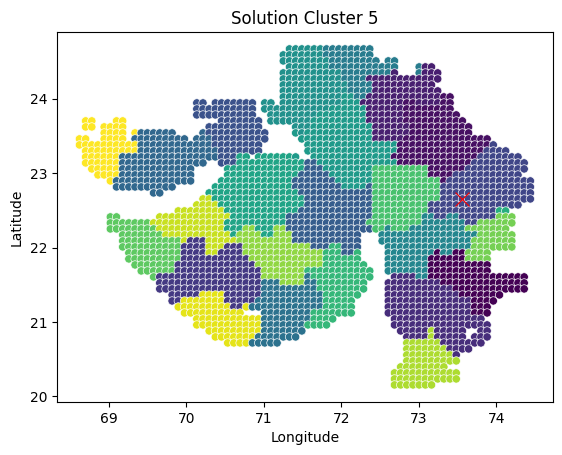

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x='Longitude', y='Latitude', 
                data=df_clus, c=df_clus['Cluster'],
                palette='coolwarm')
sns.scatterplot(x=coords[:,1], y=coords[:,0], marker='x', s=100, color='red')
plt.title(f'Solution Cluster {CLUSTER}');

C:\Users\alber\AppData\Local\Temp\ipykernel_4508\82457248.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Longitude', y='Latitude',


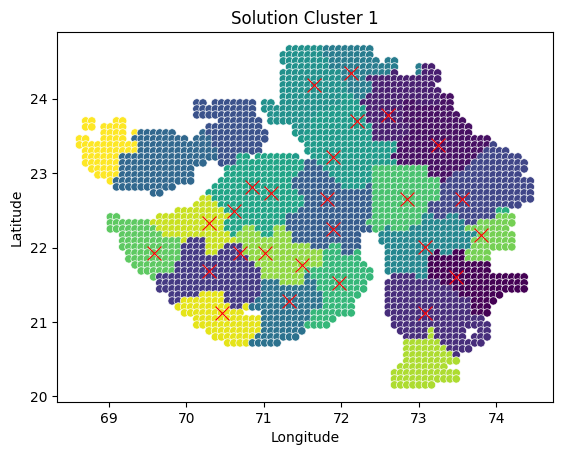

In [54]:
df_out = pd.read_csv(r"../output/clustering/solution_19_08_2023_01_15_49.csv", index_col=0)
df_out.filter(regex='x', axis=0).sum()

idxs_depots_sol = df_out.filter(regex='x_', axis=0).copy()#[df_sol['biomass'] != 0].index
idxs_depots_sol = idxs_depots_sol[idxs_depots_sol['biomass'] == 1]
idxs_depots_sol = idxs_depots_sol.index.str.split('_', expand=True).get_level_values(1).astype(int).unique()
coords = df_fc.loc[idxs_depots_sol, ['Latitude', 'Longitude']].values


import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x='Longitude', y='Latitude', 
                data=df_clus, c=df_clus['Cluster'],
                palette='coolwarm')
sns.scatterplot(x=coords[:,1], y=coords[:,0], marker='x', s=100, color='red')
plt.title(f'Solution Cluster {CLUSTER}');

In [64]:
for idx in idxs_depots_sol:
    print("Depot: ", idx)
    print(2018, "----------", df_out.filter(regex="b_2018_\d+_"+str(idx), axis=0).sum()[0])
    print(2019, "----------", df_out.filter(regex="b_2019_\d+_"+str(idx), axis=0).sum()[0])
    print("\n")

Depot:  1886
2018 ---------- 9341.658317198
2019 ---------- 7234.95468559


Depot:  564
2018 ---------- 17219.044418774
2019 ---------- 18237.541085406003


Depot:  305
2018 ---------- 11597.907594663999
2019 ---------- 11637.221648982999


Depot:  2187
2018 ---------- 17977.846952803
2019 ---------- 15113.424618862


Depot:  1638
2018 ---------- 4312.331367431
2019 ---------- 13837.471988413003


Depot:  1796
2018 ---------- 6231.625195457001
2019 ---------- 17707.910263414


Depot:  1128
2018 ---------- 9470.832269847999
2019 ---------- 10994.269135061002


Depot:  1106
2018 ---------- 11848.735700550002
2019 ---------- 15315.603388030002


Depot:  1409
2018 ---------- 8413.117478912
2019 ---------- 18430.289612776


Depot:  2081
2018 ---------- 13235.638033094003
2019 ---------- 18547.532869467002


Depot:  79
2018 ---------- 5173.655143393001
2019 ---------- 5243.005283404001


Depot:  1605
2018 ---------- 20000.000000000004
2019 ---------- 20000.000000000015


Depot:  122
2018 ---

In [74]:
ls_x = df_out.filter(regex='x_', axis=0)